In [1]:
!git clone https://github.com/davda54/sam

fatal: destination path 'sam' already exists and is not an empty directory.


In [2]:
from sam.sam import SAM

In [3]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
from itertools import product
import pickle
import time

In [4]:
MNIST_train = torchvision.datasets.MNIST('./', train=True, download=True)
MNIST_test = torchvision.datasets.MNIST('./', train=False, download=True)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [6]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
resume = True

if resume: 
    with open('drive/MyDrive/diplom/small/sam_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sam = arr["acc"]
        test_loss_history_sam = arr["loss"]
        loss_in_training_sam = arr["loss_train"]
        time_learning_sam = arr["time"]
else:
    test_accuracy_history_sam, test_loss_history_sam, loss_in_training_sam, time_learning_sam = {}, {}, {}, {}

In [9]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sam:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    base_optimizer = torch.optim.SGD
    optimizer = SAM(lenet5.parameters(), base_optimizer, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    batch_size = 100
    
    test_loss_history_sam[key] = list()
    test_accuracy_history_sam[key] = list()
    loss_in_training_sam[key] = list()
    time_learning_sam[key] = list()

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        
        start_time = time.time()
        
        for start_index in range(0, len(X_train), batch_size):
            # optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.first_step(zero_grad=True)
            
            preds_2 = lenet5.forward(X_batch)
            loss_value_2 = loss(preds_2, y_batch)
            loss_value_2.backward()
            optimizer.second_step(zero_grad=True)
        
        time_learning_sam[key].append(time.time() - start_time)
        loss_in_training_sam[key].append(float(loss(lenet5.forward(X_train), y_train)))
        print(loss_in_training_sam[key])
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_sam[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_sam[key].append(accuracy)
    
    print(test_accuracy_history_sam[(learning_rate, weight_decay)])
    print(loss_in_training_sam[(learning_rate, weight_decay)])
    with open('drive/MyDrive/diplom/small/sam_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [7]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']
import matplotlib.pyplot as plt

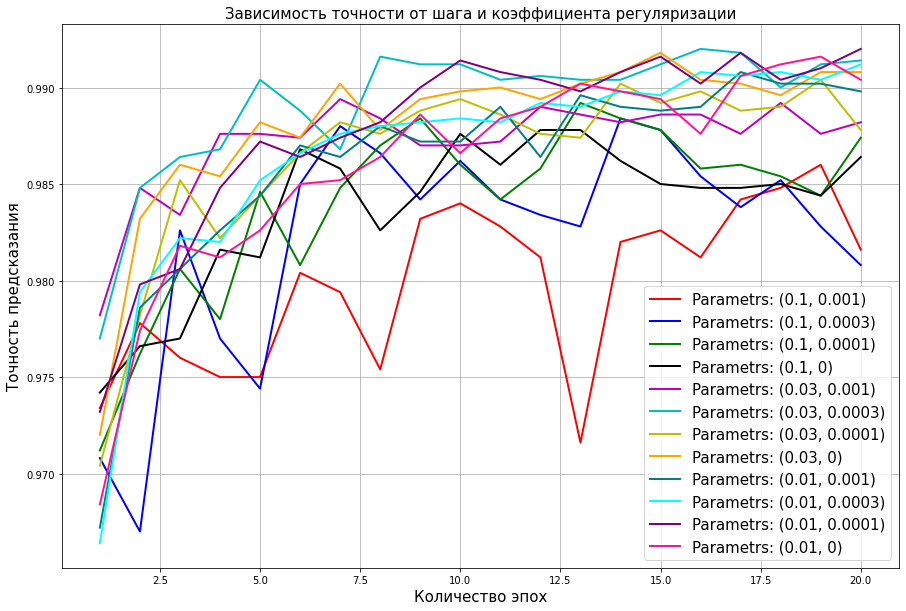

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sam.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_accrucy.png')

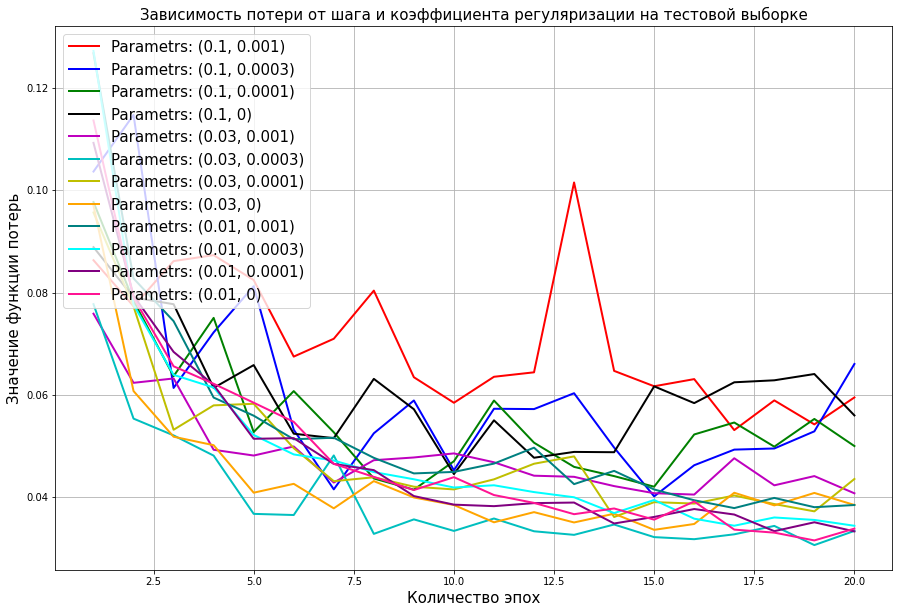

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sam.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_1_loss.png')

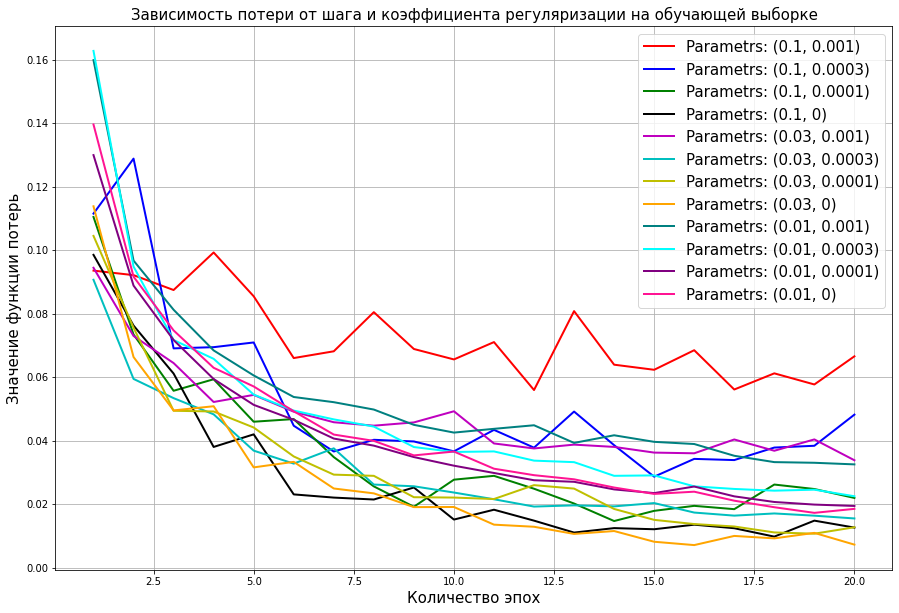

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sam.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_loss_train.png')

In [14]:
resume = False

if resume: 
    with open('drive/MyDrive/diplom/small/sam_rho_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sam = arr["acc"]
        test_loss_history_sam = arr["loss"]
        loss_in_training_sam = arr["loss_train"]
        time_learning_sam = arr["time"]
else:
    test_accuracy_history_sam, test_loss_history_sam, loss_in_training_sam, time_learning_sam = {}, {}, {}, {}

In [15]:
import tqdm
for p in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
    
    key = p
    if key in test_accuracy_history_sam:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    base_optimizer = torch.optim.SGD
    optimizer = SAM(lenet5.parameters(), base_optimizer, rho=p, lr=0.01, momentum=0.9, weight_decay=0.001)
    batch_size = 100
    
    test_loss_history_sam[key] = list()
    test_accuracy_history_sam[key] = list()
    loss_in_training_sam[key] = list()
    time_learning_sam[key] = list()

    for epoch in tqdm.tqdm(range(20)):
        order = np.random.permutation(len(X_train))
        
        start_time = time.time()
        
        for start_index in range(0, len(X_train), batch_size):
            # optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.first_step(zero_grad=True)
            
            preds_2 = lenet5.forward(X_batch)
            loss_value_2 = loss(preds_2, y_batch)
            loss_value_2.backward()
            optimizer.second_step(zero_grad=True)
        
        time_learning_sam[key].append(time.time() - start_time)
        loss_in_training_sam[key].append(float(loss(lenet5.forward(X_train), y_train)))
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_sam[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_sam[key].append(accuracy)
    
    print(test_accuracy_history_sam[key])
    print(loss_in_training_sam[key])
    with open('drive/MyDrive/diplom/small/sam_rho_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

100%|██████████| 20/20 [11:21<00:00, 34.06s/it]


[tensor(0.9722), tensor(0.9788), tensor(0.9826), tensor(0.9830), tensor(0.9836), tensor(0.9864), tensor(0.9866), tensor(0.9878), tensor(0.9888), tensor(0.9886), tensor(0.9872), tensor(0.9894), tensor(0.9900), tensor(0.9912), tensor(0.9882), tensor(0.9900), tensor(0.9882), tensor(0.9904), tensor(0.9904), tensor(0.9892)]
[0.14270293712615967, 0.0947982668876648, 0.07897008210420609, 0.07142849266529083, 0.061690058559179306, 0.051724761724472046, 0.05064275488257408, 0.04616888239979744, 0.04265076294541359, 0.03921787440776825, 0.04058299586176872, 0.03828500211238861, 0.038498520851135254, 0.03467660769820213, 0.03778400644659996, 0.03337322548031807, 0.04041381925344467, 0.034232594072818756, 0.03335593640804291, 0.0338517464697361]


100%|██████████| 20/20 [11:12<00:00, 33.63s/it]


[tensor(0.9698), tensor(0.9764), tensor(0.9798), tensor(0.9812), tensor(0.9848), tensor(0.9868), tensor(0.9860), tensor(0.9858), tensor(0.9872), tensor(0.9844), tensor(0.9886), tensor(0.9874), tensor(0.9886), tensor(0.9904), tensor(0.9890), tensor(0.9892), tensor(0.9892), tensor(0.9888), tensor(0.9898), tensor(0.9880)]
[0.14766491949558258, 0.09653355926275253, 0.07803072780370712, 0.07330671697854996, 0.05921905115246773, 0.05237828567624092, 0.050793275237083435, 0.04751395434141159, 0.0417056679725647, 0.04839790612459183, 0.039832282811403275, 0.04301069304347038, 0.03857319429516792, 0.035411033779382706, 0.03571011498570442, 0.03472241759300232, 0.034129686653614044, 0.03424852341413498, 0.0342392697930336, 0.03479433432221413]


100%|██████████| 20/20 [11:38<00:00, 34.91s/it]


[tensor(0.9686), tensor(0.9776), tensor(0.9818), tensor(0.9844), tensor(0.9846), tensor(0.9854), tensor(0.9858), tensor(0.9886), tensor(0.9888), tensor(0.9876), tensor(0.9880), tensor(0.9896), tensor(0.9902), tensor(0.9898), tensor(0.9890), tensor(0.9892), tensor(0.9898), tensor(0.9888), tensor(0.9896), tensor(0.9904)]
[0.14713284373283386, 0.09864325076341629, 0.07488220185041428, 0.06677232682704926, 0.06755108386278152, 0.05499706044793129, 0.0546080656349659, 0.04812624678015709, 0.048334117978811264, 0.045945726335048676, 0.042870864272117615, 0.04037274792790413, 0.03909662365913391, 0.037746869027614594, 0.03687227889895439, 0.03833751007914543, 0.036621201783418655, 0.03691268712282181, 0.03611348941922188, 0.03581134229898453]


100%|██████████| 20/20 [11:26<00:00, 34.31s/it]


[tensor(0.9704), tensor(0.9782), tensor(0.9806), tensor(0.9838), tensor(0.9860), tensor(0.9852), tensor(0.9864), tensor(0.9878), tensor(0.9872), tensor(0.9878), tensor(0.9884), tensor(0.9884), tensor(0.9886), tensor(0.9896), tensor(0.9884), tensor(0.9892), tensor(0.9886), tensor(0.9894), tensor(0.9888), tensor(0.9898)]
[0.14205148816108704, 0.0985938087105751, 0.08421298116445541, 0.07090211659669876, 0.06203649565577507, 0.058678098022937775, 0.0519246943295002, 0.04981578141450882, 0.04738878458738327, 0.04653982073068619, 0.0434253066778183, 0.04338463768362999, 0.04322309419512749, 0.03922152519226074, 0.04037954658269882, 0.03910153731703758, 0.03773628547787666, 0.035877373069524765, 0.0394255667924881, 0.036457013338804245]


100%|██████████| 20/20 [11:40<00:00, 35.03s/it]


[tensor(0.9642), tensor(0.9760), tensor(0.9800), tensor(0.9832), tensor(0.9840), tensor(0.9852), tensor(0.9876), tensor(0.9860), tensor(0.9856), tensor(0.9888), tensor(0.9876), tensor(0.9882), tensor(0.9880), tensor(0.9894), tensor(0.9914), tensor(0.9908), tensor(0.9900), tensor(0.9894), tensor(0.9898), tensor(0.9914)]
[0.1917545646429062, 0.11381272971630096, 0.0910104438662529, 0.07792501151561737, 0.07150176167488098, 0.06513504683971405, 0.0617394782602787, 0.060465265065431595, 0.055441081523895264, 0.05303885415196419, 0.0515599325299263, 0.04984736442565918, 0.04716501757502556, 0.04793071001768112, 0.045890599489212036, 0.04610981047153473, 0.044262807816267014, 0.044547539204359055, 0.04432833194732666, 0.04267427697777748]


100%|██████████| 20/20 [11:28<00:00, 34.43s/it]

[tensor(0.9602), tensor(0.9722), tensor(0.9758), tensor(0.9802), tensor(0.9834), tensor(0.9844), tensor(0.9836), tensor(0.9860), tensor(0.9852), tensor(0.9862), tensor(0.9868), tensor(0.9860), tensor(0.9872), tensor(0.9886), tensor(0.9894), tensor(0.9896), tensor(0.9896), tensor(0.9890), tensor(0.9874), tensor(0.9900)]
[0.20746389031410217, 0.13384047150611877, 0.12120512127876282, 0.09914445877075195, 0.09130831062793732, 0.08727990835905075, 0.07878586649894714, 0.07670191675424576, 0.07191259413957596, 0.06865189224481583, 0.06615187227725983, 0.06525915116071701, 0.06302233040332794, 0.0598391517996788, 0.058692991733551025, 0.057648591697216034, 0.057300418615341187, 0.0561978816986084, 0.05761061608791351, 0.05409324914216995]


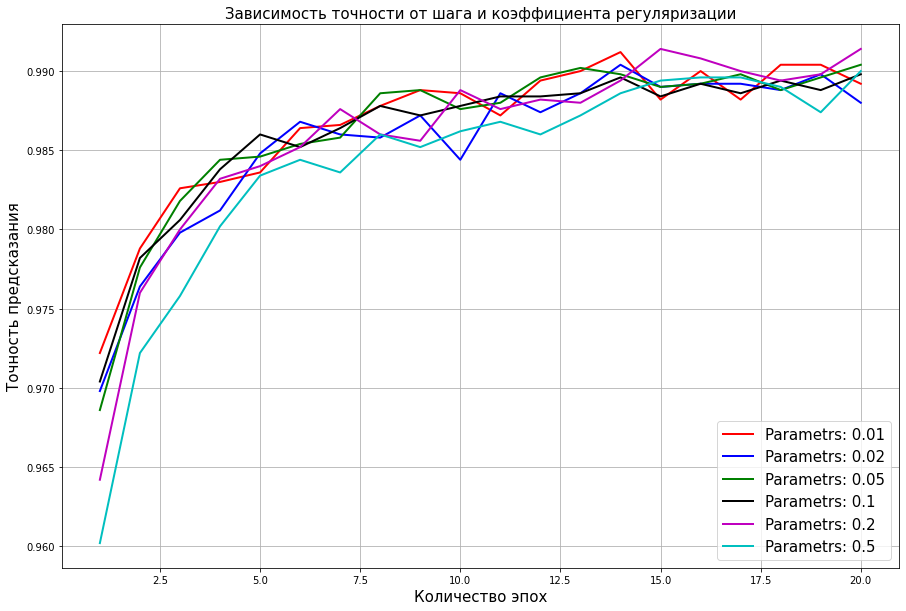

In [16]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sam.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_accrucy.png')

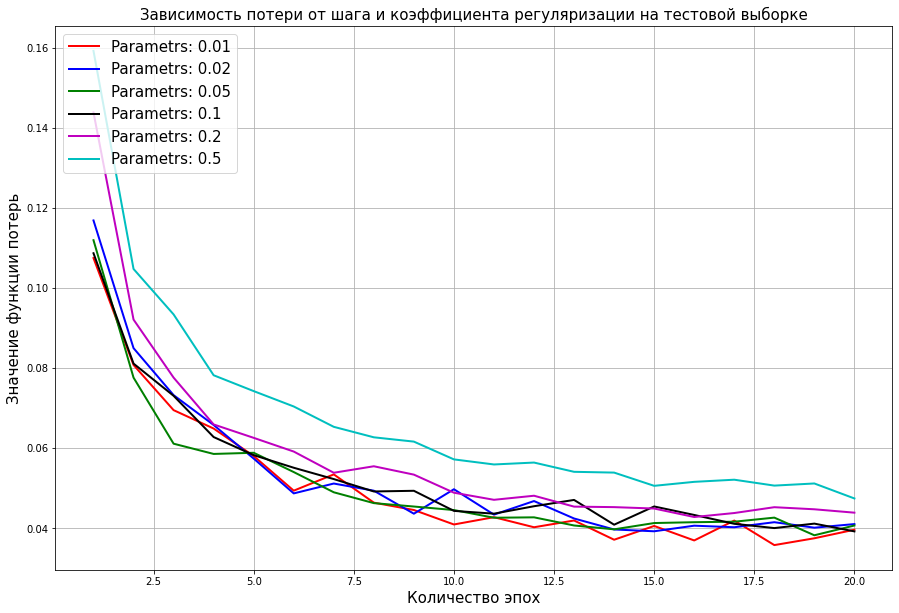

In [17]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sam.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_1_loss.png')

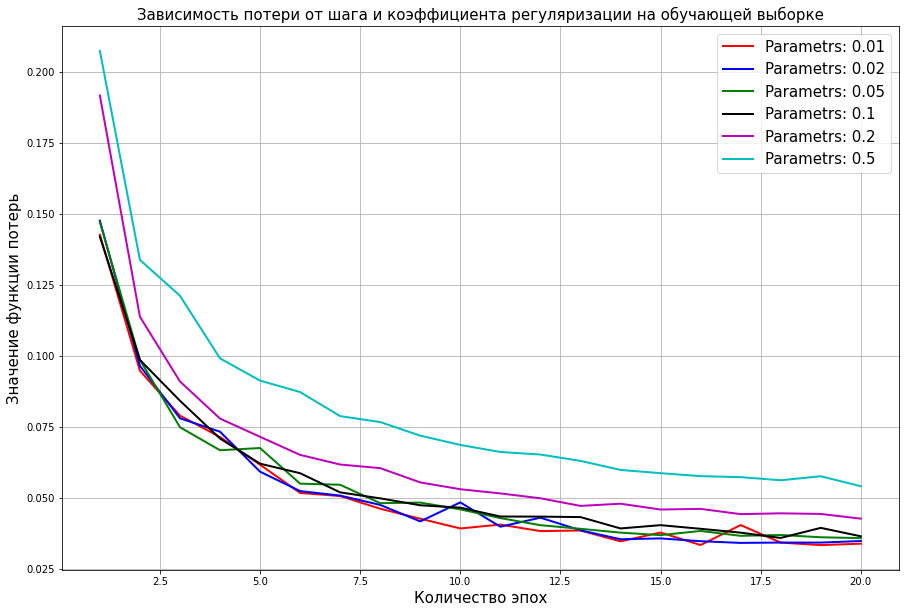

In [18]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sam.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_loss_train.png')

In [7]:
import tqdm

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
lenet5 = LeNet5()
# lenet5.cuda()
loss = torch.nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD
optimizer = SAM(lenet5.parameters(), base_optimizer, rho=0.1, lr=0.03, momentum=0.9, weight_decay=0.0003)
batch_size = 100

test_loss_history_sam = list()
test_accuracy_history_sam = list()
loss_in_training_sam = list()
time_learning_sam = list()

for epoch in tqdm.tqdm(range(20)):

    order = np.random.permutation(len(X_train))
    start_time = time.time()

    for start_index in range(0, len(X_train), batch_size):
        #optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        # X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.first_step(zero_grad=True)
        
        preds_2 = lenet5.forward(X_batch)
        loss_value_2 = loss(preds_2, y_batch)
        loss_value_2.backward()
        optimizer.second_step(zero_grad=True)

    time_learning_sam.append(time.time() - start_time)
    loss_in_training_sam.append(float(loss(lenet5.forward(X_train), y_train)))
    
    test_preds = lenet5.forward(X_test)
    test_loss_history_sam.append(loss(test_preds, y_test).data)

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_sam.append(accuracy)

with open('sam_mresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

100%|██████████| 20/20 [04:42<00:00, 14.11s/it]


In [9]:
test_accuracy_history_sam

[tensor(0.9712),
 tensor(0.9801),
 tensor(0.9833),
 tensor(0.9841),
 tensor(0.9847),
 tensor(0.9870),
 tensor(0.9875),
 tensor(0.9856),
 tensor(0.9879),
 tensor(0.9886),
 tensor(0.9891),
 tensor(0.9881),
 tensor(0.9879),
 tensor(0.9893),
 tensor(0.9897),
 tensor(0.9906),
 tensor(0.9899),
 tensor(0.9894),
 tensor(0.9908),
 tensor(0.9899)]

In [10]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [11]:
lenet5 = LeNet5()
# lenet5.cuda()
loss = torch.nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD
optimizer = SAM(lenet5.parameters(), base_optimizer, rho=0.1, lr=0.03, momentum=0.9, weight_decay=0.0003)
batch_size = 100

test_loss_history_sam = list()
test_accuracy_history_sam = list()
loss_in_training_sam = list()

start_time = time.time()
accuracy = 0

while accuracy <= 0.985:
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        #optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        # X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.first_step(zero_grad=True)
        
        preds_2 = lenet5.forward(X_batch)
        loss_value_2 = loss(preds_2, y_batch)
        loss_value_2.backward()
        optimizer.second_step(zero_grad=True)

    loss_in_training_sam.append(float(loss(lenet5.forward(X_train), y_train)))
    
    test_preds = lenet5.forward(X_test)
    test_loss_history_sam.append(loss(test_preds, y_test).data)

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_sam.append(accuracy)
    
time_learning_sam = time.time() - start_time
with open('sam_mresults_985.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

In [12]:
test_accuracy_history_sam

[tensor(0.9744),
 tensor(0.9804),
 tensor(0.9840),
 tensor(0.9850),
 tensor(0.9868)]